In [33]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline
from sklearn.linear_model import LogisticRegression as LR
from sklearn.feature_extraction import DictVectorizer as DV
from sklearn import metrics
from sklearn.model_selection import train_test_split
%pylab inline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
np.random.seed(0)

Populating the interactive namespace from numpy and matplotlib


In [34]:
data = pd.read_csv('data.csv')
data.shape
data.head()

,Grant.Status,Sponsor.Code,Grant.Category.Code,Contract.Value.Band...see.note.A,RFCD.Code.1,RFCD.Percentage.1,RFCD.Code.2,RFCD.Percentage.2,RFCD.Code.3,RFCD.Percentage.3,...,Dept.No..1,Faculty.No..1,With.PHD.1,No..of.Years.in.Uni.at.Time.of.Grant.1,Number.of.Successful.Grant.1,Number.of.Unsuccessful.Grant.1,A..1,A.1,B.1,C.1
0,1,21A,50A,A,230202.0,50.0,230203.0,30.0,230204.0,20.0,...,3098.0,31.0,Yes,>=0 to 5,2.0,0.0,0.0,4.0,2.0,0.0
1,1,4D,10A,D,320801.0,100.0,0.0,0.0,0.0,0.0,...,2553.0,25.0,Yes,>=0 to 5,3.0,1.0,0.0,2.0,0.0,0.0
2,0,NaN,NaN,NaN,320602.0,50.0,321004.0,30.0,321015.0,20.0,...,2813.0,25.0,NaN,Less than 0,1.0,5.0,0.0,7.0,2.0,0.0
3,0,51C,20C,A,291503.0,60.0,321402.0,40.0,0.0,0.0,...,2553.0,25.0,NaN,more than 15,2.0,1.0,5.0,6.0,9.0,1.0
4,0,24D,30B,NaN,380107.0,100.0,0.0,0.0,0.0,0.0,...,2923.0,25.0,NaN,Less than 0,0.0,2.0,0.0,0.0,0.0,0.0


In [35]:
X = data.drop('Grant.Status', 1)
y = data['Grant.Status']

In [36]:
numeric_cols = ['RFCD.Percentage.1', 'RFCD.Percentage.2', 'RFCD.Percentage.3', 
                'RFCD.Percentage.4', 'RFCD.Percentage.5',
                'SEO.Percentage.1', 'SEO.Percentage.2', 'SEO.Percentage.3',
                'SEO.Percentage.4', 'SEO.Percentage.5',
                'Year.of.Birth.1', 'Number.of.Successful.Grant.1', 'Number.of.Unsuccessful.Grant.1']
categorical_cols = list(set(X.columns.values.tolist()) - set(numeric_cols))

In [37]:
def calculate_means(numeric_data):
    means = np.zeros(numeric_data.shape[1])
    for j in range(numeric_data.shape[1]):
        to_sum = numeric_data.iloc[:,j]
        indices = np.nonzero(~numeric_data.iloc[:,j].isnull())[0]
        correction = np.amax(to_sum[indices])
        to_sum /= correction
        for i in indices:
            means[j] += to_sum[i]
        means[j] /= indices.size
        means[j] *= correction
    return pd.Series(means, numeric_data.columns)

def plot_scores(optimizer):
    scores = [[item[0]['C'], 
               item[1], 
               (np.sum((item[2]-item[1])**2)/(item[2].size-1))**0.5] for item in optimizer.grid_scores_]
    scores = np.array(scores)
    plt.semilogx(scores[:,0], scores[:,1])
    plt.fill_between(scores[:,0], scores[:,1]-scores[:,2], 
                                  scores[:,1]+scores[:,2], alpha=0.3)
    plt.show()

In [38]:
# place your code here
means = calculate_means(data[numeric_cols])
#print (means)

X_real_zeros = X[numeric_cols].copy()
X_cat = X[categorical_cols].copy()

X_real_zeros.fillna(0, inplace=True)
X_cat.fillna('NA', inplace=True)
X_cat = X_cat.applymap(str)

X_cat.iloc[2,2]

'0.0'

In [39]:
encoder = DV(sparse = False)
X_cat_oh = encoder.fit_transform(X_cat.T.to_dict().values())
X_cat_oh.shape

(6000, 5593)

In [40]:
param_grid = {'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10]}
cv = 3

In [41]:
# Split data
(X_train_real_zeros, 
 X_test_real_zeros, 
 y_train, y_test) = train_test_split(X_real_zeros, y, stratify=y,
                                     test_size=0.3, 
                                     random_state=0)

(X_train_cat_oh,
 X_test_cat_oh) = train_test_split(X_cat_oh, stratify=y,
                                   test_size=0.3, 
                                   random_state=0)

In [130]:
scaler = StandardScaler()
scaler.fit(X_train_real_zeros, y_train)
X_train_real_zeros_scaled = scaler.fit_transform(X_train_real_zeros)
X_test_real_zeros_scaled = scaler.fit_transform(X_test_real_zeros)

#scaler_train = StandardScaler()
#X_train_real_zeros_scaled = scaler_train.fit_transform(X_train_real_zeros)

#scaler_test = StandardScaler()
#X_test_real_zeros_scaled = scaler_test.fit_transform(X_test_real_zeros)

In [131]:
X_train = np.hstack((X_train_real_zeros_scaled, X_train_cat_oh))
X_test = np.hstack((X_test_real_zeros_scaled, X_test_cat_oh))

In [132]:
estimator = LogisticRegression(penalty='l2', class_weight='balanced', random_state = 0)
optimizer = GridSearchCV(estimator, param_grid, cv=3, n_jobs=-1)

In [133]:
optimizer.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=0,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [134]:
auc = roc_auc_score(y_test, optimizer.best_estimator_.predict_proba(X_test)[:,1])
print auc

0.879407176869


In [113]:
auc = roc_auc_score(y_test, optimizer.best_estimator_.predict_proba(X_test)[:,1])
print auc

0.879407176869


In [114]:
def write_answer_4(auc):
    with open("preprocessing_lr_answer4.txt", "w") as fout:
        fout.write(str(auc))
        
write_answer_4(auc)

In [97]:
X_train.shape 

(4200, 5606)

/home/alexbee/anaconda3/lib/python2.7/site-packages/sklearn/model_selection/_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


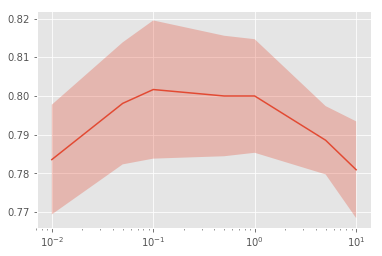

In [92]:
plot_scores(optimizer)

In [136]:
#1 Split data
(X_train_real_zeros, 
 X_test_real_zeros, 
 y_train, y_test) = train_test_split(X_real_zeros, y, stratify=y,
                                     test_size=0.3, 
                                     random_state=0)

(X_train_cat_oh,
 X_test_cat_oh) = train_test_split(X_cat_oh, stratify=y,
                                   test_size=0.3, 
                                   random_state=0)

#2 Scale                                
scaler = StandardScaler()
X_train_real_zeros_scaled = scaler.fit_transform(X_train_real_zeros)
X_test_real_zeros_scaled = scaler.fit_transform(X_test_real_zeros)

#3 Hstack
X_train = np.hstack((X_train_real_zeros_scaled, X_train_cat_oh))
X_test = np.hstack((X_test_real_zeros_scaled, X_test_cat_oh))

#4 Regression
param_grid = {'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10]}
estimator = LogisticRegression(penalty='l2', class_weight='balanced', random_state = 0)
optimizer = GridSearchCV(estimator, param_grid, cv=3)
optimizer.fit(X_train, y_train)

#5 Results
auc = roc_auc_score(y_test, optimizer.predict_proba(X_test)[:,1])
print auc

0.879407176869
